In [14]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()
DEBUG_MODE = False

###########################################################
# Utilities
###########################################################

def debug_print(msg):
    if DEBUG_MODE:
        print(msg)
        return msg

class MABs:
    def __init__(self, total_time, bandits_num):
        self.total_time = total_time
        self.bandits_num = bandits_num
        self.rng = np.random.default_rng()
        self.init_env()

    def init_env(self):
        """ Initializes all global variables
            Also sets lower and upper bounds for each bandit's rewards according to assignment's requirements
        """
        self.lower_bounds = np.zeros(self.bandits_num)
        self.upper_bounds = np.ones(self.bandits_num)
        self.pulls = np.zeros(self.bandits_num) # total number of arm pulls
        self.bandit_score = np.zeros(self.bandits_num) # total score of each bandit
        self.mu_estimate = np.inf*np.ones(self.bandits_num) # the estimate mu of each arm i until now, initialized at Inf (each bandit will be chosen at least once)
        self.expected_mu = np.zeros(self.bandits_num) # the expected mu of each arm
        self.best_score = np.zeros(self.total_time) # cumulative score of best arm at time t
        self.alg_score = np.zeros(self.total_time) # cumulative score of algorithm at time t
        self.alg_score_t = np.zeros(self.total_time) # average reward per iteration received until now
        self.inst_score = np.zeros(self.total_time) # reward of selected arm at time t
        self.regret = np.zeros(self.total_time) # average regret per iteration at round t
        self.epsilon_t = np.zeros(self.total_time) # epsilon at time t
        self.selected_arms = np.zeros(self.total_time) # selected arm at time t

        bounds = unique_random(2*self.bandits_num) # the pool of random lower (a_i) and upper (b_i) bounds
        for i in range(0, 2*self.bandits_num, 2):
            self.lower_bounds[i//2] = min(bounds[i:i+2])
            self.upper_bounds[i//2] = max(bounds[i:i+2])
            self.expected_mu[i//2] = (self.upper_bounds[i//2] + self.lower_bounds[i//2])/2

        self.best_score_t = max(self.expected_mu)*np.ones(self.total_time) # best expected reward at each time t
        self.best_score = self.best_score_t*np.arange(1,self.total_time+1)
        self.best_arm = np.argmax(self.expected_mu)


    def pick_arm(self, selected_arm, time):
        self.selected_arms[time] = selected_arm
        self.inst_score[time] = rng.uniform(low = self.lower_bounds[selected_arm], high = self.upper_bounds[selected_arm])
        self.pulls[selected_arm] += 1
        self.bandit_score[selected_arm] += self.inst_score[time]
        self.alg_score[time] = self.inst_score[time] + (self.alg_score[time-1] if time>0 else 0)
        self.alg_score_t[time] = self.alg_score[time]/(time+1)
        self.mu_estimate[selected_arm] = self.bandit_score[selected_arm]/self.pulls[selected_arm]
        self.regret[time] = (self.best_score[time] - self.alg_score[time])/(time+1)  


def unique_random(size = 1):
    """ Returns a list -of a given size- of unique random floats in the range of 0 <= x <= 1
    """
    floats = []
    floats_seen = set()
    for i in range(size):
        new_float = rng.random()
        while new_float in floats_seen:
            new_float = rng.random()
        floats_seen.add(new_float)
        floats.append(new_float)
    return floats


def epsilon_greedy(mab_obj):
    base_epsilon = 0.25
    for time in range(mab_obj.total_time):
        mab_obj.epsilon_t[time] = base_epsilon*pow(time, -1/3)*pow(np.log2(time), 1/3) if time>2 else base_epsilon # decreasing probability of picking an arm randomly based on theorem, time>2 ensures monotonic decrease
        if rng.binomial(1, mab_obj.epsilon_t[time]) == 1:
            selected_arm = rng.integers(mab_obj.bandits_num) # pick a random arm instead
        else:
            selected_arm = np.argmax(mab_obj.mu_estimate) # find best estimate so far and pick that arm
        mab_obj.pick_arm(selected_arm, time)


In [15]:
###########################################################
# Run ε-Greedy algorithm
###########################################################

mab_obj = MABs(total_time = 1000, bandits_num = 10)
epsilon_greedy(mab_obj)

epsilon_t = debug_print(mab_obj.epsilon_t)
expected_mu = debug_print(mab_obj.expected_mu)
mu_estimate = debug_print(mab_obj.mu_estimate)
selected_arms = debug_print(mab_obj.selected_arms)
pulls = debug_print(mab_obj.pulls)
best_arm = debug_print(mab_obj.best_arm)

<function matplotlib.pyplot.show(close=None, block=None)>

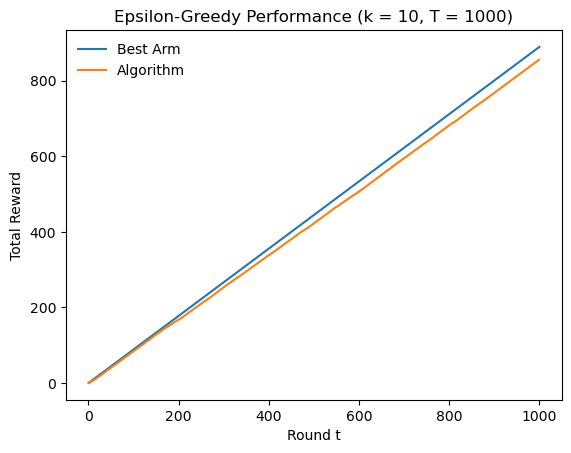

In [16]:
###########################################################
# ε-Greedy Plot Reward
###########################################################

plt.title("Epsilon-Greedy Performance (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time))
plt.xlabel("Round t")
plt.ylabel("Total Reward")
x = np.arange(1,mab_obj.total_time+1)
y = mab_obj.best_score
y2 = mab_obj.alg_score
plt.plot(x,y,y2)
plt.legend(["Best Arm", "Algorithm"], loc = "best", frameon = False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

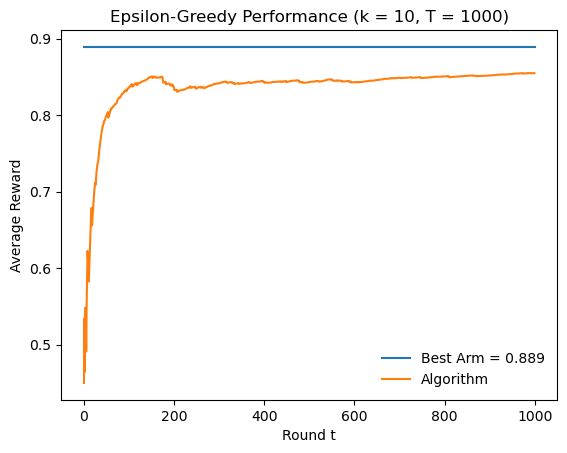

In [17]:
###########################################################
# ε-Greedy Plot Average Reward
###########################################################

plt.title("Epsilon-Greedy Performance (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time))
plt.xlabel("Round t")
plt.ylabel("Average Reward")
x = np.arange(1,mab_obj.total_time+1)
y = mab_obj.best_score_t
y2 = mab_obj.alg_score_t
plt.plot(x,y,y2)
plt.legend(["Best Arm = %0.3f" % mab_obj.best_score[0], "Algorithm"], loc = "best", frameon = False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

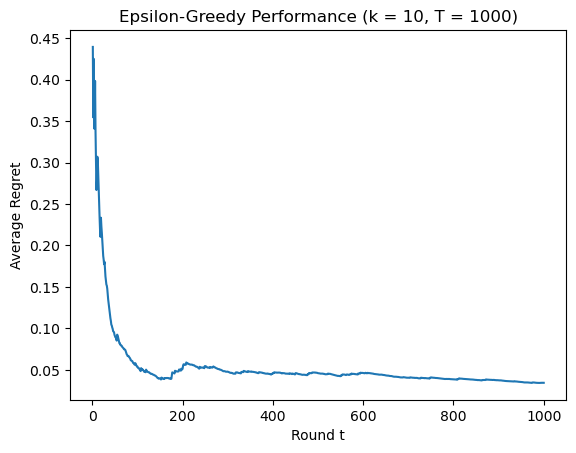

In [18]:
###########################################################
# ε-Greedy Plot Regret
###########################################################

plt.title("Epsilon-Greedy Performance (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time))
plt.xlabel("Round t")
plt.ylabel("Average Regret")
x = np.arange(1,mab_obj.total_time+1)
y = mab_obj.regret
plt.plot(x,y)
plt.show